## Pipeline notebook Parkinson's Disease (PD)
This notebook contains results of the network AI pipleline using PD as a case study. It contains files generated from the pipeline, the analysis of those files and visulisations that can be derived from the files.

In [1]:
# import relevant libraries
import requests
import json
import sys
from sklearn.model_selection import StratifiedKFold,cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from random import randrange
import pygraphviz as pgv
from pyvis.network import Network
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import gensim.models.keyedvectors as word2vec
%matplotlib inline

## Loading the target and control network files

In [2]:
# load the target relations file
pos_df = pd.read_csv("/homes/fabadmus/Internship/PDtest2/TWDIS_06685", sep='\t')
print(len(pos_df))

# load the control relations file
neg_df = pd.read_csv("/homes/fabadmus/Internship/PDtest2/TWDIS_09536",sep='\t' )
print(len(neg_df))

94
160


In [3]:
# load the file that contains the combined network. This is essential for labelling later in the model training stage
full_df = pd.read_csv('/homes/fabadmus/Internship/PDtest2/model_data_path', sep='\t')
full_df

,Unnamed: 0,subject,object,local_mi,label
0,0,TWDIS_06685,TWMET_00170,1333443,POS
1,1,TWDIS_06685,TWMET_00012,575453,POS
2,2,TWDIS_06685,TWMET_01157,86789,POS
3,4,TWDIS_06685,TWMET_00848,12038,POS
4,7,TWDIS_06685,TWMET_00014,5061,POS
...,...,...,...,...,...
131,249,TWDIS_09536,TWMET_00245,110,NEG
132,250,TWDIS_09536,TWMET_00868,110,NEG
133,251,TWDIS_09536,TWMET_00347,109,NEG
134,252,TWDIS_09536,TWMET_00534,102,NEG


In [4]:
# checking the size of the control concepts
len(full_df[full_df.label =='NEG'])

101

## Initial visualizations of the target and control networks.

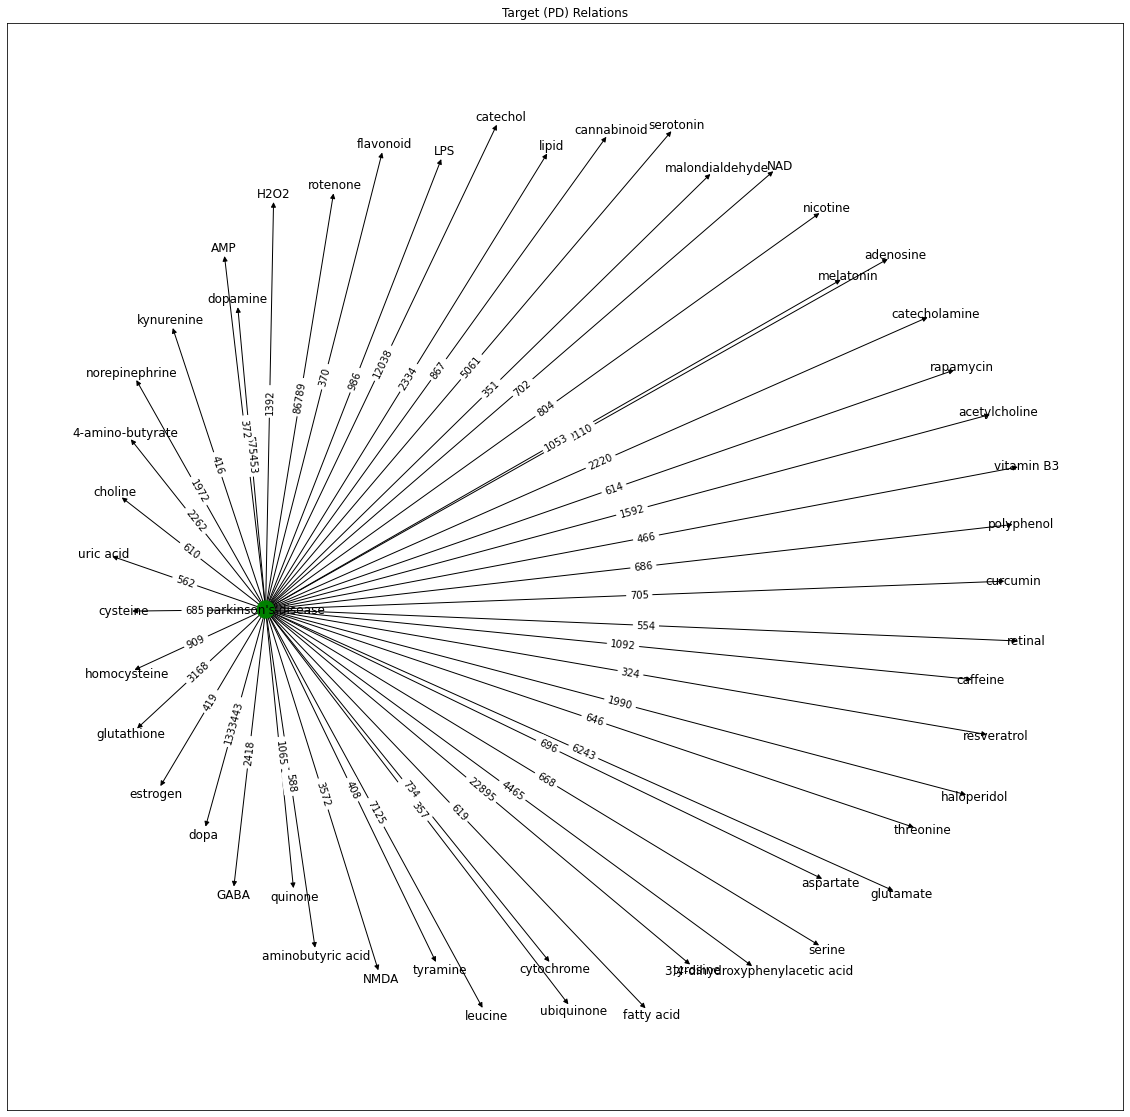

In [5]:
# convert target relations to graph
df_park = pd.read_csv('/homes/fabadmus/Internship/PDtest2/TWDIS_06685', sep='\t')

g = nx.from_pandas_edgelist(df_park.iloc[:51,:], "subject_annotated", "object_annotated", 'local_mi',
                            create_using=nx.DiGraph)
# plot the graph
plt.figure(10, figsize=(20, 20))
pos = nx.spring_layout(g, weight='local_mi', iterations=80)
color_map = ['green' if node.startswith("park") else 'none' for node in g.nodes] 
nx.draw_networkx(g, node_color=color_map , pos=pos)
nx.draw_networkx_edge_labels(g, 
pos=pos, 
edge_labels=nx.get_edge_attributes(g, 'local_mi'),
font_color="black",
);
plt.title('Target (PD) Relations')
plt.grid(visible=False)
plt.show()

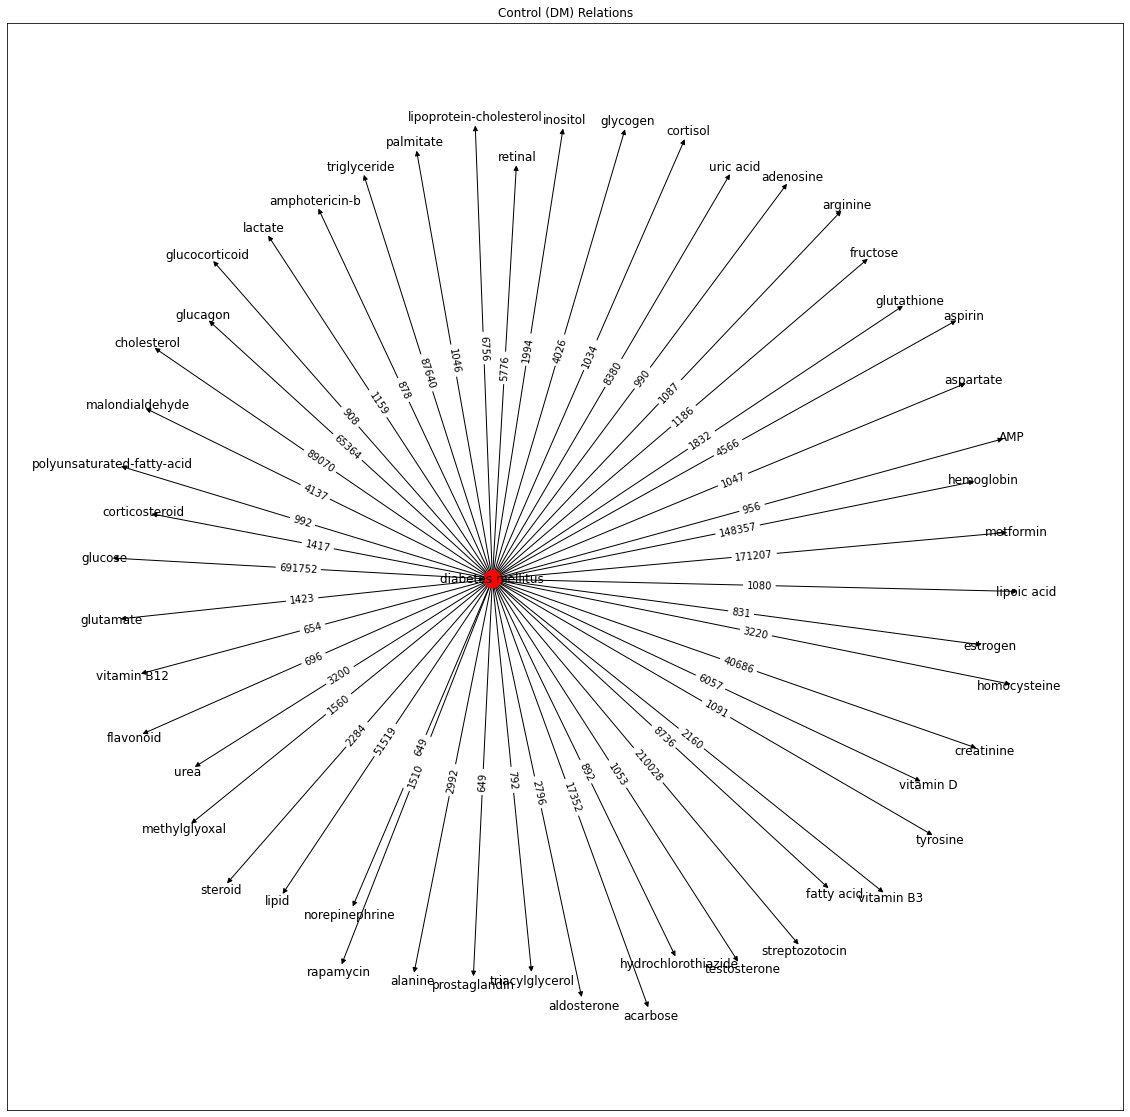

In [6]:
# convert control relations to graph
df_dm = pd.read_csv('/homes/fabadmus/Internship/PDtest2/TWDIS_09536', sep='\t')
g = nx.from_pandas_edgelist(df_dm.iloc[:51,:], "subject_annotated", "object_annotated", 'local_mi',
                            create_using=nx.DiGraph)
# plot the graph
plt.figure(10, figsize=(20, 20))
pos = nx.spring_layout(g, weight='local_mi', iterations=80)
color_map = ['red' if node.startswith("diab") else 'none' for node in g.nodes] 
nx.draw_networkx(g, node_color=color_map , pos=pos)
nx.draw_networkx_edge_labels(g, 
pos=pos, 
edge_labels=nx.get_edge_attributes(g, 'local_mi'),
font_color="black",
);
plt.title('Control (DM) Relations')
plt.grid(visible=False)
plt.show()

## Analysis of the second layer of the network

In [7]:
# load the file containing the second layer relations
second_layer = pd.read_csv('/homes/fabadmus/Internship/PDtest2/second_layer', sep='\t')
second_layer

,Unnamed: 0,subject,object,local_mi
0,0,TWMET_00001,TWMET_00011,596442
1,1,TWMET_00001,TWMET_00411,453310
2,2,TWMET_00002,TWMET_00003,1888164
3,3,TWMET_00002,TWMET_00011,1576366
4,4,TWMET_00003,TWMET_00011,4343986
...,...,...,...,...
17791,17791,TWMET_01235,TWMET_01030,360
17792,17792,TWMET_01235,TWMET_01100,4
17793,17793,TWMET_01235,TWMET_01151,7
17794,17794,TWMET_01235,TWMET_01158,18


### Visualization of the second layer

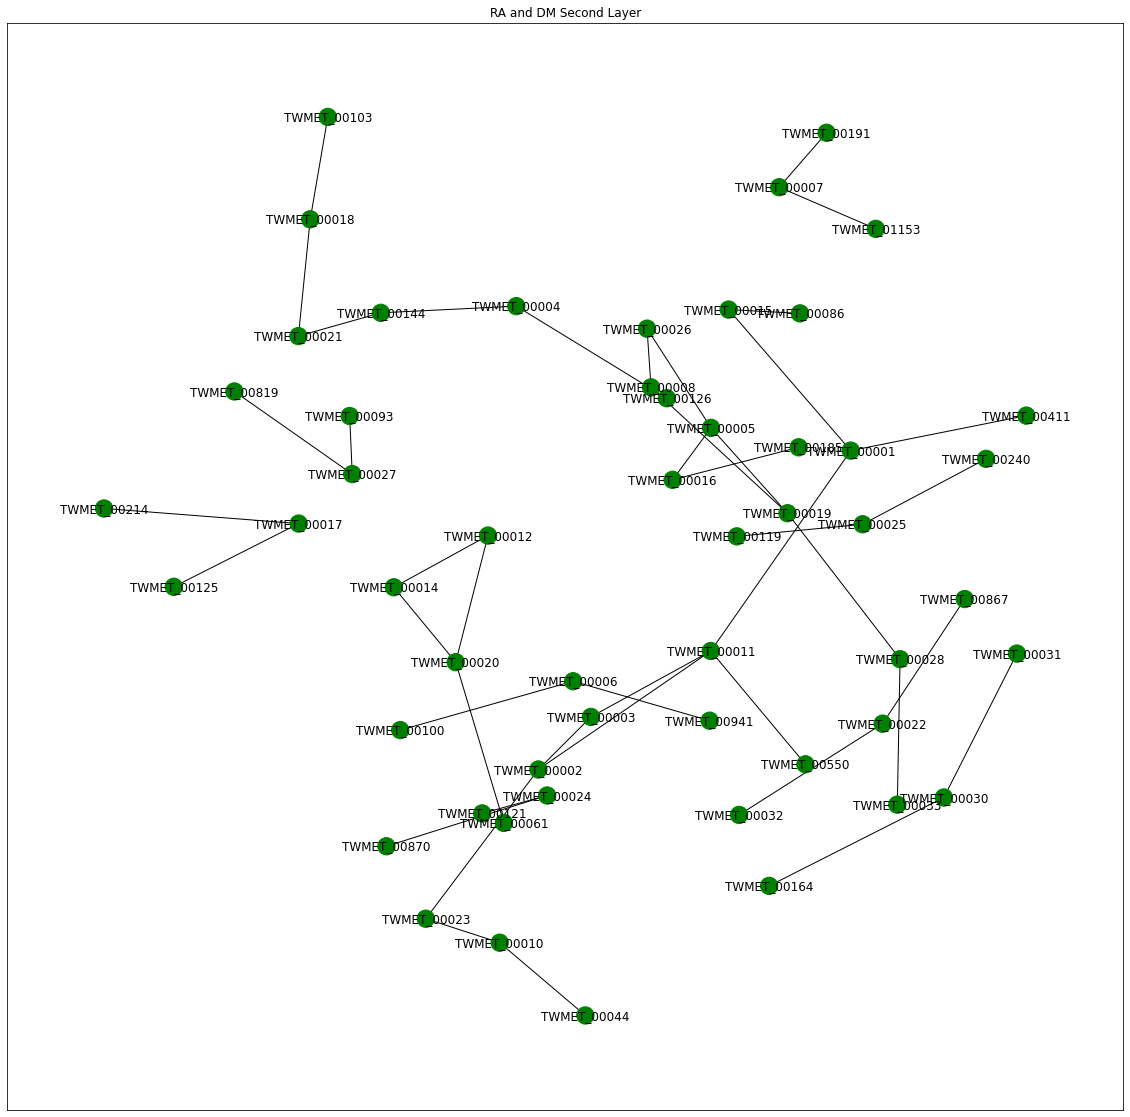

In [8]:
# load the second layer file 
full_second_layer = pd.read_csv('/homes/fabadmus/Internship/PDtest2/second_layer', sep='\t')

# plotting only the first 50 rows for visibility reasons
g = nx.from_pandas_edgelist(full_second_layer.iloc[:51,:], source='subject',
                            target='object')
# plot the graph
plt.figure(10, figsize=(20, 20))
pos = nx.spring_layout(g, weight='local_mi', iterations=10)


color_map = ['red' if node.startswith("TWDIS") else 'green' for node in g.nodes] 
nx.draw_networkx(g, node_color=color_map , pos=pos)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=nx.get_edge_attributes(g, 'local_mi'), font_color="black",
);
plt.title('RA and DM Second Layer')
plt.grid(visible=False)
plt.show()

In [9]:
# convert the second_layer into a graph
G = nx.from_pandas_edgelist(full_second_layer, source='subject',
                            target='object', edge_attr='local_mi', edge_key='local_mi')

### Analysis of embedding dimensions

In [10]:
# load embedding file and load into a dataframe
embeddings = word2vec.KeyedVectors.load_word2vec_format('/homes/fabadmus/Internship/PDtest2/full_emb.emb')
emb_df = (pd.DataFrame([embeddings.get_vector(str(n))

                        for n in G.nodes()], index=G.nodes))



emb_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
TWMET_00001,0.877961,-0.264814,-0.184483,0.791087,1.393956,-0.910327,-0.445294,0.275530,0.148568,-0.137062,...,0.543539,-0.063265,0.100619,0.327286,0.797783,0.513700,0.485005,-1.393494,-0.331185,0.640141
TWMET_00011,0.057249,-1.237029,-0.052443,0.721449,0.481923,-0.722016,-0.278754,0.571238,-0.952143,0.599840,...,-0.635397,0.127436,1.330009,0.645482,1.375810,0.742411,-0.534429,-0.566988,-0.123586,0.468812
TWMET_00411,0.885249,-0.014156,-0.355393,0.799947,0.826511,-0.761122,-0.194443,-0.185747,0.196626,-0.092140,...,0.438969,-0.203033,-0.020991,-0.008612,0.479859,0.421351,0.184651,-1.150723,-0.158686,0.471715
TWMET_00002,0.402263,-0.851939,0.561332,0.100380,0.348775,0.032718,-0.256988,0.681173,-0.495583,0.378040,...,-0.288502,0.619121,0.915563,1.346197,1.156597,0.500265,-0.587553,-0.645070,-0.133421,0.319151
TWMET_00003,0.450014,-0.983699,0.261186,0.266491,0.550052,-0.539098,-0.271029,0.961774,-0.933037,0.216142,...,-0.443432,0.308132,1.177955,1.265097,1.204557,0.683700,-0.309348,-0.549257,-0.323943,0.556137
TWMET_00004,-0.018532,-1.317896,1.983694,0.857895,-0.616061,0.667250,-0.110872,0.512737,0.911751,1.008730,...,0.653312,-0.091825,0.947498,1.067679,-0.345826,0.046087,-1.015536,-0.158173,-0.505606,-0.412547
TWMET_00144,-0.095752,-1.114774,1.823977,1.120661,-0.833346,0.957623,-0.528978,0.910057,0.686431,1.610771,...,0.867095,-0.026678,0.400836,0.825712,-0.604649,0.146592,-1.054918,-0.739273,-0.566710,-0.515378
TWMET_00126,0.572463,-0.817326,0.637464,1.017027,-1.870324,0.397769,0.236153,1.307349,1.682710,0.541592,...,0.235916,-0.524728,1.527894,1.301093,-0.207569,0.610745,-1.118859,0.404240,0.651122,-0.650648
TWMET_00005,0.918669,0.183218,0.862449,0.392261,0.099831,-1.280767,0.102967,0.128145,0.811252,1.177816,...,-0.306242,0.087742,-0.667049,-0.158375,0.772028,-0.058552,-0.325050,0.824674,-0.866478,0.066676
TWMET_00026,0.820553,0.336316,0.383718,0.577596,-0.250440,-1.085096,0.672211,-0.082527,0.761747,1.010099,...,0.297103,0.153009,-0.214939,-0.413386,1.099239,0.043906,-0.121378,0.484777,-0.525740,-0.023718


In [11]:
# get set of positive and negative concepts from the full data saved earlier for labelling
pos = set(full_df[full_df['label'] == 'POS'].object)
neg = set(full_df[full_df['label'] == 'NEG'].object)

In [12]:
# label embeddings according to the set 
emb_df.loc[emb_df.index.isin(pos), 'SET'] = 'POS'
emb_df.loc[emb_df.index.isin(neg), 'SET'] = 'NEG'
emb_df.loc[emb_df.SET.isnull(), 'SET'] = 'UNK'

In [13]:
# confirm size of the groups
print(len(emb_df.loc[emb_df.SET == 'UNK']))
print(len(emb_df.loc[emb_df.SET == 'POS']))
print(len(emb_df.loc[emb_df.SET == 'NEG']))

166
35
101


In [14]:
emb_df.loc[emb_df.SET == 'UNK']

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,SET
TWMET_00411,0.885249,-0.014156,-0.355393,0.799947,0.826511,-0.761122,-0.194443,-0.185747,0.196626,-0.092140,...,-0.203033,-0.020991,-0.008612,0.479859,0.421351,0.184651,-1.150723,-0.158686,0.471715,UNK
TWMET_00002,0.402263,-0.851939,0.561332,0.100380,0.348775,0.032718,-0.256988,0.681173,-0.495583,0.378040,...,0.619121,0.915563,1.346197,1.156597,0.500265,-0.587553,-0.645070,-0.133421,0.319151,UNK
TWMET_00004,-0.018532,-1.317896,1.983694,0.857895,-0.616061,0.667250,-0.110872,0.512737,0.911751,1.008730,...,-0.091825,0.947498,1.067679,-0.345826,0.046087,-1.015536,-0.158173,-0.505606,-0.412547,UNK
TWMET_00144,-0.095752,-1.114774,1.823977,1.120661,-0.833346,0.957623,-0.528978,0.910057,0.686431,1.610771,...,-0.026678,0.400836,0.825712,-0.604649,0.146592,-1.054918,-0.739273,-0.566710,-0.515378,UNK
TWMET_00026,0.820553,0.336316,0.383718,0.577596,-0.250440,-1.085096,0.672211,-0.082527,0.761747,1.010099,...,0.153009,-0.214939,-0.413386,1.099239,0.043906,-0.121378,0.484777,-0.525740,-0.023718,UNK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TWMET_00465,-0.140536,0.330382,-0.102837,0.444819,0.719012,-0.098188,0.181787,-0.546256,-0.002430,-0.114166,...,-0.296254,-0.387709,-0.545224,-0.379405,0.428268,-0.098771,-0.743616,0.258434,0.512657,UNK
TWMET_01173,0.156702,-0.258521,0.474939,0.524016,-0.300868,0.289964,0.136640,0.381145,0.294750,0.164905,...,-0.238942,0.261310,0.100919,-0.121257,0.110591,-0.345759,0.167980,0.068427,-0.001265,UNK
TWMET_00840,0.232496,0.052312,-0.260851,-0.090442,0.561463,-0.649752,0.391751,-0.267160,0.033020,-0.881520,...,-0.995730,-0.114622,-0.826090,0.032066,-0.091928,-1.110755,-0.768644,0.148146,0.625943,UNK
TWMET_00547,0.210334,0.177879,-0.207407,-0.099840,0.346446,0.255929,0.790967,-0.528653,0.873913,-0.161594,...,0.414151,0.014239,-0.652465,-0.490361,0.096801,0.373727,-1.127375,1.015306,0.030062,UNK


### Linear discriminant analysis of embeddings

In [15]:
# set input and output variables from the embedding dataframe
X = emb_df.iloc[:,:-1].values
y = emb_df['SET']
target_names = set(emb_df.SET.values)


# initializing the model with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)

# fitting the dataset
X_r2 = lda.fit(X, y).transform(X)

### Visualizing the LDA

In [16]:
# Creating a dataframe for the visalization from the LDA values
plot_df = pd.DataFrame(X_r2)
plot_df['SET'] = emb_df['SET'].values

In [17]:
# mapping the colors for the groups
colors = {'NEG':'red', 'POS' : 'green', 'UNK':'black'}
plot_df['color'] = plot_df['SET'].map(colors)

In [18]:
# keeping only the target and control embedding values to show their distribution
plot_df = plot_df[(plot_df.SET == 'NEG')|(plot_df.SET == 'POS')]
plot_df.head(10)

,0,1,SET,color
0,-1.500639,-0.998918,NEG,red
1,-2.370421,-1.481852,NEG,red
4,-1.856222,-2.126767,NEG,red
7,-1.963983,-2.316595,NEG,red
8,-2.063335,-0.727097,NEG,red
16,0.750757,-0.423594,NEG,red
20,1.333158,1.173092,POS,green
21,-1.791232,-2.259708,NEG,red
22,4.377110,-1.892197,POS,green
24,3.460998,-1.175168,POS,green


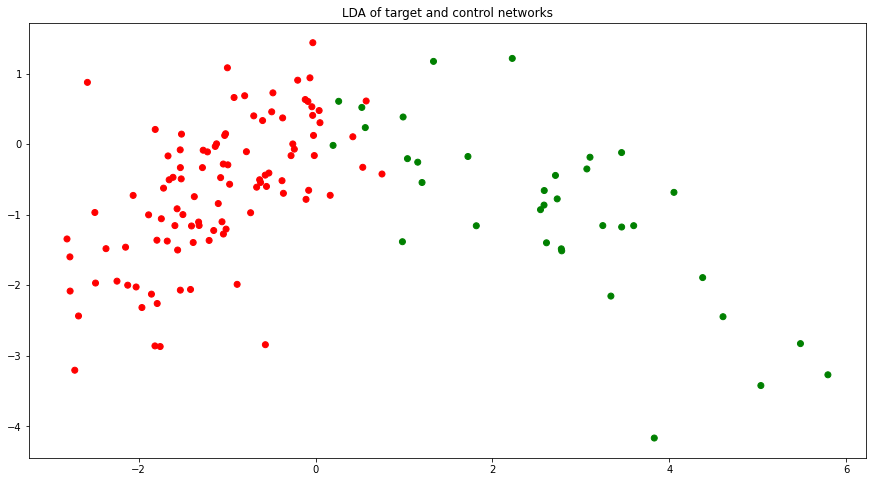

In [19]:
# plotting the graph
plt.figure(figsize=(15, 8))
plt.scatter(plot_df[0],plot_df[1], c=plot_df.color)
plt.title('LDA of target and control networks')
plt.grid(visible=False)
plt.show()

### Create a modeling data

In [15]:
# extract embeddings for the target and control networks from the embedding dataframe for model training
model_df = emb_df.loc[(emb_df.SET == 'POS') | (emb_df.SET == 'NEG')]
model_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,SET
TWMET_00001,0.877961,-0.264814,-0.184483,0.791087,1.393956,-0.910327,-0.445294,0.275530,0.148568,-0.137062,...,-0.063265,0.100619,0.327286,0.797783,0.513700,0.485005,-1.393494,-0.331185,0.640141,NEG
TWMET_00011,0.057249,-1.237029,-0.052443,0.721449,0.481923,-0.722016,-0.278754,0.571238,-0.952143,0.599840,...,0.127436,1.330009,0.645482,1.375810,0.742411,-0.534429,-0.566988,-0.123586,0.468812,NEG
TWMET_00003,0.450014,-0.983699,0.261186,0.266491,0.550052,-0.539098,-0.271029,0.961774,-0.933037,0.216142,...,0.308132,1.177955,1.265097,1.204557,0.683700,-0.309348,-0.549257,-0.323943,0.556137,NEG
TWMET_00126,0.572463,-0.817326,0.637464,1.017027,-1.870324,0.397769,0.236153,1.307349,1.682710,0.541592,...,-0.524728,1.527894,1.301093,-0.207569,0.610745,-1.118859,0.404240,0.651122,-0.650648,NEG
TWMET_00005,0.918669,0.183218,0.862449,0.392261,0.099831,-1.280767,0.102967,0.128145,0.811252,1.177816,...,0.087742,-0.667049,-0.158375,0.772028,-0.058552,-0.325050,0.824674,-0.866478,0.066676,NEG


### Analysis of the distances between the embeddings to establish similarity

In [16]:
# get pairwise distances 
dist = metrics.pairwise_distances(X=model_df.iloc[:,:-1], Y=model_df.iloc[:,:-1], metric="cosine")

In [17]:
# convert the distances into a dataframe
dist = pd.DataFrame(dist)
dist.head()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,0.000000,0.282810,0.264909,0.869681,1.035231e+00,1.156398,0.998187,0.466158,1.167994,1.249330,...,1.016139,0.996659,0.982511,1.171773,1.202352,0.800620,1.166144,1.229581,0.923653,1.143364
1,0.282810,0.000000,0.032136,0.757801,1.074959e+00,1.031660,1.022851,0.084187,1.206014,1.203551,...,0.936439,1.033404,0.896689,1.077352,1.067734,1.003970,1.105895,1.139036,0.965315,1.190477
2,0.264909,0.032136,0.000000,0.746587,1.079206e+00,1.002337,1.018140,0.139871,1.270406,1.257054,...,0.990610,1.066994,0.920496,1.102738,1.119349,1.048207,1.149204,1.140260,0.961657,1.195789
3,0.869681,0.757801,0.746587,0.000000,9.999790e-01,0.614754,1.135141,0.680413,1.164521,1.028236,...,0.911645,0.995110,0.985862,0.932629,1.119481,1.229586,0.666555,0.733363,0.727308,0.918504
4,1.035231,1.074959,1.079206,0.999979,1.192093e-07,0.852460,1.144218,1.098958,0.939957,0.941280,...,0.814157,0.494243,0.878599,0.738823,0.792731,1.142684,1.025599,0.770534,0.959135,0.926737


In [18]:
# assign index according to the original modelling embedding dataframe
dist.index = model_df.index

# assign column names according to the culumns of the original modelling embedding dataframe
names = list(model_df.index)
dist.columns = names

# reset index and inspect
dist = dist.reset_index()
dist.head()

,index,TWMET_00001,TWMET_00011,TWMET_00003,TWMET_00126,TWMET_00005,TWMET_01153,TWMET_00044,TWMET_00550,TWMET_00012,...,TWMET_00824,TWMET_00868,TWMET_00893,TWMET_00905,TWMET_00988,TWMET_01031,TWMET_01051,TWMET_01152,TWMET_01157,TWMET_01201
0,TWMET_00001,0.000000,0.282810,0.264909,0.869681,1.035231e+00,1.156398,0.998187,0.466158,1.167994,...,1.016139,0.996659,0.982511,1.171773,1.202352,0.800620,1.166144,1.229581,0.923653,1.143364
1,TWMET_00011,0.282810,0.000000,0.032136,0.757801,1.074959e+00,1.031660,1.022851,0.084187,1.206014,...,0.936439,1.033404,0.896689,1.077352,1.067734,1.003970,1.105895,1.139036,0.965315,1.190477
2,TWMET_00003,0.264909,0.032136,0.000000,0.746587,1.079206e+00,1.002337,1.018140,0.139871,1.270406,...,0.990610,1.066994,0.920496,1.102738,1.119349,1.048207,1.149204,1.140260,0.961657,1.195789
3,TWMET_00126,0.869681,0.757801,0.746587,0.000000,9.999790e-01,0.614754,1.135141,0.680413,1.164521,...,0.911645,0.995110,0.985862,0.932629,1.119481,1.229586,0.666555,0.733363,0.727308,0.918504
4,TWMET_00005,1.035231,1.074959,1.079206,0.999979,1.192093e-07,0.852460,1.144218,1.098958,0.939957,...,0.814157,0.494243,0.878599,0.738823,0.792731,1.142684,1.025599,0.770534,0.959135,0.926737


In [19]:
# melt the dataframe to show all pairwise distances
dist = dist.melt('index', var_name='X', value_name='Values')

# remove self distances and inspect
dist = dist[dist['index'] != dist['X']]
dist.head()

,index,X,Values
1,TWMET_00011,TWMET_00001,0.282810
2,TWMET_00003,TWMET_00001,0.264909
3,TWMET_00126,TWMET_00001,0.869681
4,TWMET_00005,TWMET_00001,1.035231
5,TWMET_01153,TWMET_00001,1.156398


In [20]:
# sort dataframes to show the shortest between pairs
dist.sort_values(by =['Values'] )

,index,X,Values
15480,TWMET_00243,TWMET_00451,0.003689
15345,TWMET_00451,TWMET_00243,0.003689
6166,TWMET_00322,TWMET_00805,0.007807
6301,TWMET_00805,TWMET_00322,0.007807
11783,TWMET_00269,TWMET_00157,0.009504
...,...,...,...
11657,TWMET_00181,TWMET_00155,1.416958
47,TWMET_00059,TWMET_00001,1.432679
6392,TWMET_00001,TWMET_00059,1.432679
6755,TWMET_00848,TWMET_00233,1.436636


In [21]:
dist.sort_values(by=['Values'])

,index,X,Values
15480,TWMET_00243,TWMET_00451,0.003689
15345,TWMET_00451,TWMET_00243,0.003689
6166,TWMET_00322,TWMET_00805,0.007807
6301,TWMET_00805,TWMET_00322,0.007807
11783,TWMET_00269,TWMET_00157,0.009504
...,...,...,...
11657,TWMET_00181,TWMET_00155,1.416958
47,TWMET_00059,TWMET_00001,1.432679
6392,TWMET_00001,TWMET_00059,1.432679
6755,TWMET_00848,TWMET_00233,1.436636


In [22]:
session  = requests.Session()
base_url = 'https://apimlqv2.tenwiseservice.nl/api/mlquery/'
session.headers['referer'] = 'https://apimlqv2.tenwiseservice.nl/'
session.get(base_url + "start/")
payload = {'hanze2022': sys.argv[1],
           'csrfmiddlewaretoken': session.cookies.get_dict()['csrftoken']}

In [23]:
obj_list = list(dist['X'])
sbj_list = list(dist['index'])
concept_list = obj_list + sbj_list

In [24]:
# get list of concepts
# concept_list = list(dist['index'])
payload['concept_ids'] = ",".join(concept_list)
results = session.post(base_url + 'conceptset/annotation/', payload)
js = results.json()

annotation = js['result']['annotation']

# print(names)

In [25]:
def annotate(concept):
    return annotation[concept]['name'][0]
dist['subject_annotation'] = dist['index'].apply(annotate)
dist['object_annotation'] = dist['X'].apply(annotate)

In [26]:
dist.sort_values(by=['Values'])[:20]

,index,X,Values,subject_annotation,object_annotation
15480,TWMET_00243,TWMET_00451,0.003689,inulin,inulin
15345,TWMET_00451,TWMET_00243,0.003689,inulin,inulin
6166,TWMET_00322,TWMET_00805,0.007807,4-amino-butyrate,aminobutyric acid
6301,TWMET_00805,TWMET_00322,0.007807,aminobutyric acid,4-amino-butyrate
11783,TWMET_00269,TWMET_00157,0.009504,trimethoprim,ciprofloxacin
11918,TWMET_00157,TWMET_00269,0.009504,ciprofloxacin,trimethoprim
3013,TWMET_00028,TWMET_00033,0.010840,testosterone,androgen
2878,TWMET_00033,TWMET_00028,0.010840,androgen,testosterone
14384,TWMET_00192,TWMET_00245,0.011600,rifampicin,isoniazid
14249,TWMET_00245,TWMET_00192,0.011600,isoniazid,rifampicin


In [27]:
# targ_set = set(dist)
# dist['set'] = 
dist.loc[dist['index'].isin(pos), 'Disease'] = 'Parkinsons'
dist.loc[dist['index'].isin(neg), 'Disease'] = 'Diabetes'


In [28]:
dist.sort_values(by=['Values'])[:30]

,index,X,Values,subject_annotation,object_annotation,Disease
15480,TWMET_00243,TWMET_00451,0.003689,inulin,inulin,Diabetes
15345,TWMET_00451,TWMET_00243,0.003689,inulin,inulin,Diabetes
6166,TWMET_00322,TWMET_00805,0.007807,4-amino-butyrate,aminobutyric acid,Parkinsons
6301,TWMET_00805,TWMET_00322,0.007807,aminobutyric acid,4-amino-butyrate,Parkinsons
11783,TWMET_00269,TWMET_00157,0.009504,trimethoprim,ciprofloxacin,Diabetes
11918,TWMET_00157,TWMET_00269,0.009504,ciprofloxacin,trimethoprim,Diabetes
3013,TWMET_00028,TWMET_00033,0.010840,testosterone,androgen,Diabetes
2878,TWMET_00033,TWMET_00028,0.010840,androgen,testosterone,Diabetes
14384,TWMET_00192,TWMET_00245,0.011600,rifampicin,isoniazid,Diabetes
14249,TWMET_00245,TWMET_00192,0.011600,isoniazid,rifampicin,Diabetes


### Create validation data from the embedding data

In [29]:
validation_df = emb_df.loc[emb_df.SET == 'UNK']
validation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,SET
TWMET_00411,0.885249,-0.014156,-0.355393,0.799947,0.826511,-0.761122,-0.194443,-0.185747,0.196626,-0.092140,...,-0.203033,-0.020991,-0.008612,0.479859,0.421351,0.184651,-1.150723,-0.158686,0.471715,UNK
TWMET_00002,0.402263,-0.851939,0.561332,0.100380,0.348775,0.032718,-0.256988,0.681173,-0.495583,0.378040,...,0.619121,0.915563,1.346197,1.156597,0.500265,-0.587553,-0.645070,-0.133421,0.319151,UNK
TWMET_00004,-0.018532,-1.317896,1.983694,0.857895,-0.616061,0.667250,-0.110872,0.512737,0.911751,1.008730,...,-0.091825,0.947498,1.067679,-0.345826,0.046087,-1.015536,-0.158173,-0.505606,-0.412547,UNK
TWMET_00144,-0.095752,-1.114774,1.823977,1.120661,-0.833346,0.957623,-0.528978,0.910057,0.686431,1.610771,...,-0.026678,0.400836,0.825712,-0.604649,0.146592,-1.054918,-0.739273,-0.566710,-0.515378,UNK
TWMET_00026,0.820553,0.336316,0.383718,0.577596,-0.250440,-1.085096,0.672211,-0.082527,0.761747,1.010099,...,0.153009,-0.214939,-0.413386,1.099239,0.043906,-0.121378,0.484777,-0.525740,-0.023718,UNK


In [30]:
print(len(model_df))

136


In [31]:
# assign the independent and dependent variables
X = model_df.iloc[:,:-1].values
y = model_df['SET']

## Train multiple models

In [54]:
from lazypredict.Supervised import LazyClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models = pd.DataFrame(models)
models

100%|██████████| 29/29 [00:00<00:00, 37.62it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.88,0.83,None,0.87,0.03
LogisticRegression,0.85,0.81,None,0.85,0.01
NearestCentroid,0.83,0.79,None,0.83,0.01
ExtraTreesClassifier,0.85,0.79,None,0.85,0.10
SGDClassifier,0.78,0.78,None,0.79,0.01
Perceptron,0.78,0.76,None,0.78,0.01
BernoulliNB,0.80,0.75,None,0.80,0.01
DecisionTreeClassifier,0.80,0.75,None,0.80,0.01
BaggingClassifier,0.80,0.75,None,0.80,0.04


## ADABOOST

In [94]:
from sklearn.ensemble import AdaBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8048780487804879


In [95]:
# predict unknowns
X_val = validation_df.iloc[:,:-1]
unk_pred_ada = model.predict(X_val)

In [96]:
val_proba = model.predict_proba(X_val)

In [97]:
# convert predictions and actual values to dataframe
val_proba_df = pd.DataFrame(val_proba, index=X_val.index,
                                columns=['NEG_prob', 'POS_prob'])
val_proba_df['predictions'] =unk_pred_ada
val_proba_df = val_proba_df.sort_values('POS_prob', ascending=False)
val_proba_df

,NEG_prob,POS_prob,predictions
TWMET_00105,0.34,0.66,POS
TWMET_00772,0.37,0.63,POS
TWMET_00173,0.38,0.62,POS
TWMET_01184,0.38,0.62,POS
TWMET_01043,0.39,0.61,POS
...,...,...,...
TWMET_00411,0.78,0.22,NEG
TWMET_00002,0.78,0.22,NEG
TWMET_00547,0.79,0.21,NEG
TWMET_00039,0.80,0.20,NEG


In [98]:
session = requests.Session()
base_url = 'https://apimlqv2.tenwiseservice.nl/api/mlquery/'
session.headers['referer'] = 'https://apimlqv2.tenwiseservice.nl'
session.get(f"{base_url}start/")

payload = {'apikey': '',
           'csrfmiddlewaretoken': session.cookies.get_dict()['csrftoken']}

# annotate predictions
ids = list(val_proba_df.index)
payload['concept_ids'] = ",".join(ids)
results = session.post(f"{base_url}conceptset/annotation/", payload)
js = results.json()
annotation = js['result']['annotation']
# get ids
annotated_ids = []
for id in ids:
    annotated_ids.extend(annotation[id]['name'])
# add ids to the dataframe
val_proba_df['annotation'] = annotated_ids
val_proba_df = val_proba_df.sort_values('POS_prob', ascending=False)
val_proba_df.head(20)

,NEG_prob,POS_prob,predictions,annotation
TWMET_00105,0.34,0.66,POS,glutamine
TWMET_00772,0.37,0.63,POS,5-methoxytryptamine
TWMET_00173,0.38,0.62,POS,melatonin
TWMET_01184,0.38,0.62,POS,sulpiride
TWMET_01043,0.39,0.61,POS,methionine sulfoximine
TWMET_00575,0.39,0.61,POS,3-hydroxykynurenine
TWMET_00584,0.39,0.61,POS,kynurenic acid
TWMET_00552,0.40,0.60,POS,tryptamine
TWMET_01100,0.41,0.59,POS,octopamine
TWMET_00991,0.41,0.59,POS,hydroquinone


## Random Forest

In [32]:
# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42) 

In [33]:
param_grid = {'min_samples_leaf':[3,5,7,10,15],'max_features':[0.5,'sqrt','log2'],
          'max_depth':[10,15,20],
          'class_weight':[{"POS":3,"NEG":1},{"POS":1,"NEG":1}],
          'criterion':['entropy','gini']}


model1 = GridSearchCV(RandomForestClassifier(),param_grid, verbose=1,n_jobs=-1,scoring='roc_auc')
model1.fit(X_train,y_train)
print ('\n',model1.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits

 RandomForestClassifier(class_weight={'NEG': 1, 'POS': 1}, max_depth=10,
                       max_features=0.5, min_samples_leaf=15)


In [34]:
pred1 = model1.predict(X_test)
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

         NEG       0.88      0.94      0.91        31
         POS       0.75      0.60      0.67        10

    accuracy                           0.85        41
   macro avg       0.81      0.77      0.79        41
weighted avg       0.85      0.85      0.85        41



/commons/conda/firdaws_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


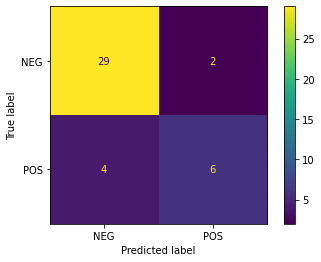

In [35]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model1, X_test, y_test)

plt.show()

/commons/conda/firdaws_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


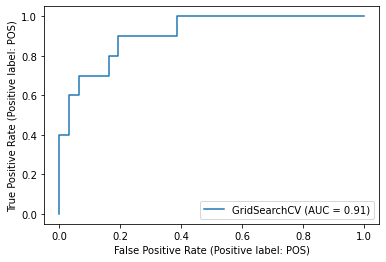

In [36]:
metrics.plot_roc_curve(model1, X_test, y_test)


In [37]:
model2 = RandomForestClassifier(random_state=42)

model2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
pred2 = model2.predict(X_test)
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

         NEG       0.88      0.97      0.92        31
         POS       0.86      0.60      0.71        10

    accuracy                           0.88        41
   macro avg       0.87      0.78      0.81        41
weighted avg       0.88      0.88      0.87        41



/commons/conda/firdaws_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


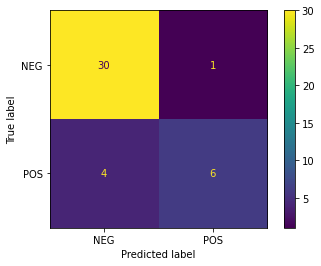

In [39]:
plot_confusion_matrix(model2, X_test, y_test)

plt.show()

/commons/conda/firdaws_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


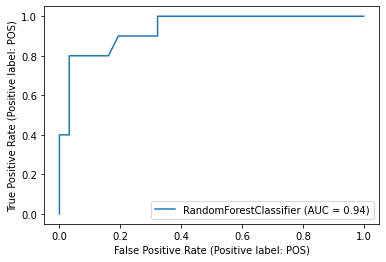

In [40]:
metrics.plot_roc_curve(model2, X_test, y_test)


In [41]:
# predict unknowns
X_val = validation_df.iloc[:,:-1]
unk_pred = model2.predict(X_val)

In [42]:
val_proba = model2.predict_proba(X_val)

In [43]:
# convert predictions and actual values to dataframe
val_proba_df = pd.DataFrame(val_proba, index=X_val.index,
                                columns=['NEG_prob', 'POS_prob'])
val_proba_df['predictions'] =unk_pred
val_proba_df = val_proba_df.sort_values('POS_prob', ascending=False)
val_proba_df

,NEG_prob,POS_prob,predictions
TWMET_01184,0.06,0.94,POS
TWMET_00717,0.14,0.86,POS
TWMET_00224,0.20,0.80,POS
TWMET_01100,0.27,0.73,POS
TWMET_00067,0.35,0.65,POS
...,...,...,...
TWMET_00411,0.95,0.05,NEG
TWMET_00074,0.96,0.04,NEG
TWMET_00249,0.96,0.04,NEG
TWMET_00160,0.97,0.03,NEG


In [44]:
session = requests.Session()
base_url = 'https://apimlqv2.tenwiseservice.nl/api/mlquery/'
session.headers['referer'] = 'https://apimlqv2.tenwiseservice.nl'
session.get(f"{base_url}start/")

payload = {'apikey': '',
           'csrfmiddlewaretoken': session.cookies.get_dict()['csrftoken']}

# annotate predictions
ids = list(val_proba_df.index)
payload['concept_ids'] = ",".join(ids)
results = session.post(f"{base_url}conceptset/annotation/", payload)
js = results.json()
annotation = js['result']['annotation']
# get ids
annotated_ids = []
for id in ids:
    annotated_ids.extend(annotation[id]['name'])
# add ids to the dataframe
val_proba_df['annotation'] = annotated_ids
val_proba_df = val_proba_df.sort_values('POS_prob', ascending=False)
val_proba_df.head(20)

,NEG_prob,POS_prob,predictions,annotation
TWMET_01184,0.06,0.94,POS,sulpiride
TWMET_00717,0.14,0.86,POS,3-methoxytyramine
TWMET_00224,0.20,0.80,POS,chlorpheniramine
TWMET_01100,0.27,0.73,POS,octopamine
TWMET_00067,0.35,0.65,POS,morphine
TWMET_00552,0.37,0.63,POS,tryptamine
TWMET_00991,0.38,0.62,POS,hydroquinone
TWMET_00062,0.38,0.62,POS,histidine
TWMET_01141,0.39,0.61,POS,pyrazole
TWMET_00027,0.39,0.61,POS,acetylcholine


In [45]:
pd.DataFrame.to_csv(val_proba_df, '/homes/fabadmus/Internship/grad_project/first_emb_result', sep='\t')
val_proba_df

,NEG_prob,POS_prob,predictions,annotation
TWMET_01184,0.06,0.94,POS,sulpiride
TWMET_00717,0.14,0.86,POS,3-methoxytyramine
TWMET_00224,0.20,0.80,POS,chlorpheniramine
TWMET_01100,0.27,0.73,POS,octopamine
TWMET_00067,0.35,0.65,POS,morphine
...,...,...,...,...
TWMET_00411,0.95,0.05,NEG,glucagon
TWMET_00074,0.96,0.04,NEG,penicillin
TWMET_00249,0.96,0.04,NEG,long-chain-fatty-acid
TWMET_00160,0.97,0.03,NEG,erythromycin


In [46]:
# make predictions on the unknown
#X_val = validation_df.iloc[:,:-1]
X_val = emb_df.iloc[:,:-1]
pred = model2.predict(X_val)

In [47]:
val_proba = model2.predict_proba(X_val)

In [48]:
# convert predictions and actual values to dataframe
val_proba_df = pd.DataFrame(val_proba, index=X_val.index,
                                columns=['NEG_prob', 'POS_prob'])
val_proba_df['predictions'] = pred
val_proba_df = val_proba_df.sort_values('POS_prob', ascending=False)
val_proba_df

,NEG_prob,POS_prob,predictions
TWMET_00059,0.04,0.96,POS
TWMET_00166,0.05,0.95,POS
TWMET_00170,0.05,0.95,POS
TWMET_01184,0.06,0.94,POS
TWMET_00012,0.06,0.94,POS
...,...,...,...
TWMET_00130,0.99,0.01,NEG
TWMET_00095,0.99,0.01,NEG
TWMET_00157,0.99,0.01,NEG
TWMET_00163,0.99,0.01,NEG


In [49]:
val_proba_df.index.names = ['ID']

In [50]:
emb_df.index.names = ['ID']


In [51]:
emb_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,SET
ID,,,,,,,,,,,,,,,,,,,,,
TWMET_00001,0.877961,-0.264814,-0.184483,0.791087,1.393956,-0.910327,-0.445294,0.275530,0.148568,-0.137062,...,-0.063265,0.100619,0.327286,0.797783,0.513700,0.485005,-1.393494,-0.331185,0.640141,NEG
TWMET_00011,0.057249,-1.237029,-0.052443,0.721449,0.481923,-0.722016,-0.278754,0.571238,-0.952143,0.599840,...,0.127436,1.330009,0.645482,1.375810,0.742411,-0.534429,-0.566988,-0.123586,0.468812,NEG
TWMET_00411,0.885249,-0.014156,-0.355393,0.799947,0.826511,-0.761122,-0.194443,-0.185747,0.196626,-0.092140,...,-0.203033,-0.020991,-0.008612,0.479859,0.421351,0.184651,-1.150723,-0.158686,0.471715,UNK
TWMET_00002,0.402263,-0.851939,0.561332,0.100380,0.348775,0.032718,-0.256988,0.681173,-0.495583,0.378040,...,0.619121,0.915563,1.346197,1.156597,0.500265,-0.587553,-0.645070,-0.133421,0.319151,UNK
TWMET_00003,0.450014,-0.983699,0.261186,0.266491,0.550052,-0.539098,-0.271029,0.961774,-0.933037,0.216142,...,0.308132,1.177955,1.265097,1.204557,0.683700,-0.309348,-0.549257,-0.323943,0.556137,NEG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TWMET_01157,0.157006,0.025862,0.291540,0.292070,0.105367,0.060689,0.197574,-0.081420,0.107929,-0.180781,...,-0.112128,0.002343,0.181387,-0.040108,-0.020000,-0.218743,0.072081,0.151775,0.086284,POS
TWMET_00840,0.232496,0.052312,-0.260851,-0.090442,0.561463,-0.649752,0.391751,-0.267160,0.033020,-0.881520,...,-0.995730,-0.114622,-0.826090,0.032066,-0.091928,-1.110755,-0.768644,0.148146,0.625943,UNK
TWMET_01201,0.176286,0.114098,-0.298497,-0.246345,0.234800,0.396858,0.808170,-0.442618,0.951618,-0.107561,...,0.594802,0.126849,-0.686702,-0.477901,0.041930,0.404439,-1.157865,1.095838,-0.087615,NEG


In [52]:
# sourcery skip: avoid-builtin-shadow
predictions_df = pd.merge(emb_df['SET'],val_proba_df, how = 'left', on = 'ID')
predictions_df

,SET,NEG_prob,POS_prob,predictions
ID,,,,
TWMET_00001,NEG,0.92,0.08,NEG
TWMET_00011,NEG,0.99,0.01,NEG
TWMET_00411,UNK,0.95,0.05,NEG
TWMET_00002,UNK,0.95,0.05,NEG
TWMET_00003,NEG,0.98,0.02,NEG
...,...,...,...,...
TWMET_01157,POS,0.23,0.77,POS
TWMET_00840,UNK,0.89,0.11,NEG
TWMET_01201,NEG,0.89,0.11,NEG


In [53]:
len(predictions_df.index)

302

In [54]:
session = requests.Session()
base_url = 'https://apimlqv2.tenwiseservice.nl/api/mlquery/'
session.headers['referer'] = 'https://apimlqv2.tenwiseservice.nl'
session.get(f"{base_url}start/")

payload = {'apikey': '',
           'csrfmiddlewaretoken': session.cookies.get_dict()['csrftoken']}

# annotate predictions
ids = list(predictions_df.index)
payload['concept_ids'] = ",".join(ids)
results = session.post(f"{base_url}conceptset/annotation/", payload)
js = results.json()
annotation = js['result']['annotation']
# get ids
annotated_ids = []
for id in ids:
    annotated_ids.extend(annotation[id]['name'])
# add ids to the dataframe
predictions_df['annotation'] = annotated_ids
predictions_df = predictions_df.sort_values('POS_prob', ascending=False)
predictions_df.head(10)

,SET,NEG_prob,POS_prob,predictions,annotation
ID,,,,,
TWMET_00059,POS,0.04,0.96,POS,histamine
TWMET_00166,POS,0.05,0.95,POS,haloperidol
TWMET_00170,POS,0.05,0.95,POS,dopa
TWMET_01184,UNK,0.06,0.94,POS,sulpiride
TWMET_00012,POS,0.06,0.94,POS,dopamine
TWMET_00574,POS,0.07,0.93,POS,"3,4-dihydroxyphenylacetic acid"
TWMET_00804,POS,0.09,0.91,POS,aminobutyric acid
TWMET_00848,POS,0.09,0.91,POS,catechol
TWMET_00322,POS,0.12,0.88,POS,4-amino-butyrate


In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np


/tmp/ipykernel_2502557/944821638.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


/tmp/ipykernel_2502557/324505898.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(predictions_df.POS_prob, predictions_df.SET, alpha=0.2, cmap='viridis')


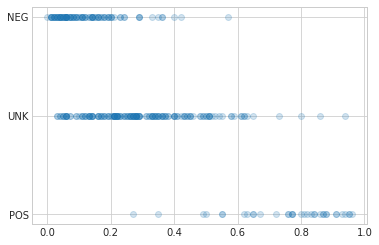

In [56]:
plt.scatter(predictions_df.POS_prob, predictions_df.SET, alpha=0.2, cmap='viridis')

/tmp/ipykernel_2502557/2035391487.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(predictions_df.POS_prob, predictions_df.NEG_prob, c=predictions_df.SET.map(colors), s=predictions_df.predictions.map(sizes),alpha=0.3, cmap='viridis')


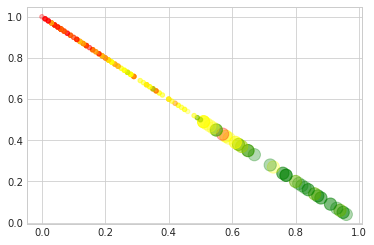

In [57]:
colors = {"POS":'green', "NEG":'red', "UNK":'yellow'}
sizes = {"POS":150, "NEG":20}
plt.scatter(predictions_df.POS_prob, predictions_df.NEG_prob, c=predictions_df.SET.map(colors), s=predictions_df.predictions.map(sizes),alpha=0.3, cmap='viridis')

(array([68., 62., 54., 39., 18., 19., 14.,  4., 12., 12.]),
 array([0.   , 0.096, 0.192, 0.288, 0.384, 0.48 , 0.576, 0.672, 0.768,
        0.864, 0.96 ]),
 <BarContainer object of 10 artists>)

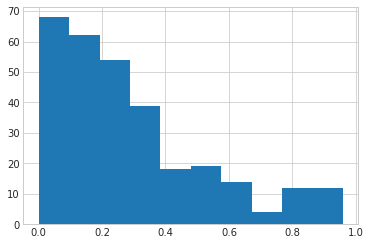

In [58]:
colors = {"POS":'green', "NEG":'red', "UNK":'yellow'}
plt.hist(
    predictions_df.POS_prob,
    label=predictions_df.predictions,

)

/tmp/ipykernel_2502557/3610982998.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df.loc[df.SET=='POS', "POS_prob"] , color="green", label="POS")
/tmp/ipykernel_2502557/3610982998.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df.loc[df.SET=='NEG', "POS_prob"] , color="red", label="NE

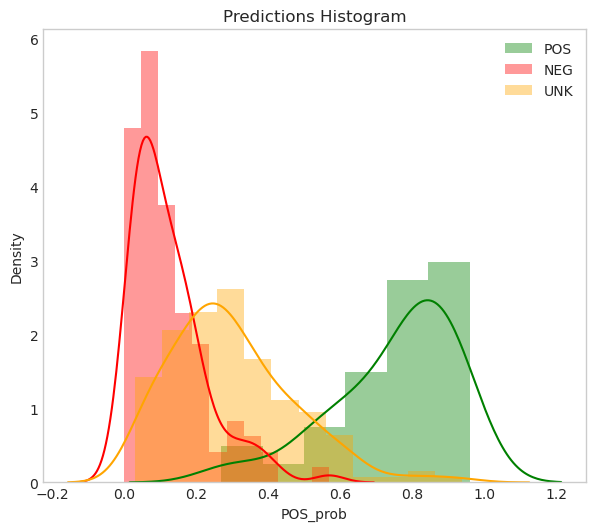

In [59]:
# Plot distribution curves

df = predictions_df

plt.subplots(figsize=(7,6), dpi=100)
sns.distplot( df.loc[df.SET=='POS', "POS_prob"] , color="green", label="POS")
sns.distplot( df.loc[df.SET=='NEG', "POS_prob"] , color="red", label="NEG")
sns.distplot( df.loc[df.SET=='UNK', "POS_prob"] , color="orange", label="UNK")
plt.grid(b=None)
plt.title('Predictions Histogram')
plt.legend();

/tmp/ipykernel_2502557/351059110.py:2: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


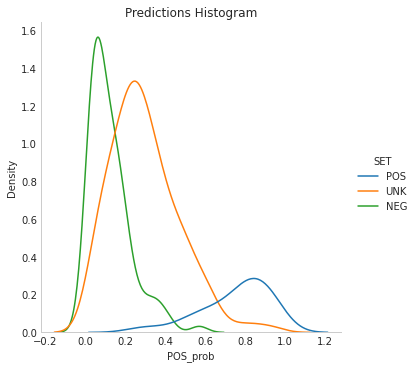

In [60]:

sns.displot(df, x="POS_prob", hue="SET", kind="kde")
plt.grid(b=None)
plt.title('Predictions Histogram')
plt.legend();